## Train model using contrastive loss with ontology strategies

In [3]:
import os
import sys
import random

p = os.path.abspath('../')
sys.path.insert(1, p)

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

import transformers
transformers.logging.set_verbosity_error()

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

from datasets import Dataset, load_dataset, Split

import seaborn as sns
sns.set_theme(color_codes=True)

from transformers import DataCollatorWithPadding, AutoModel, Trainer, TrainingArguments
import evaluate

from src.contrastive_transformers.collators import TextCollator
from src.contrastive_transformers.datasets import AutoAugmentDataset, DatasetWithPositives
from src.contrastive_transformers.trainers import ContrastiveTrainer
from src.contrastive_transformers.losses import SupConLoss 

from src.utils.utils import * 

seed = 7631
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
smm4h20 = load_dataset('KevinSpaghetti/smm4h20')
cadec = load_dataset('KevinSpaghetti/cadec')

meddra_ontology = pd.read_csv('./data/processed/meddra_ontology.csv')
all_pts = meddra_ontology['term_PT'].unique()

llt_pt_examples = pd.read_csv('./data/processed/llt_pt_examples.csv')
all_llts = llt_pt_examples['term_LLT'].unique()

llt_to_pt_mapping = dict(llt_pt_examples[['term_LLT', 'term_PT']].itertuples(index=False))

all_pts = load_dataset('KevinSpaghetti/all_pts', split=Split.ALL)
pt_vocab = dict(zip(all_pts['term'], all_pts['label']))
index_to_label = dict(zip(all_pts['label'], all_pts['term']))
print(len(pt_vocab))

Using custom data configuration KevinSpaghetti--smm4h20-9b0cef5ffb10261f
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--smm4h20-9b0cef5ffb10261f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration KevinSpaghetti--cadec-d97aca76af8be810
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--cadec-d97aca76af8be810/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration KevinSpaghetti--all_pts-28f171117b934745
Found cached dataset parquet (/home/kevinds/.cache/huggingface/datasets/KevinSpaghetti___parquet/KevinSpaghetti--all_pts-28f171117b934745/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


24571


In [5]:
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
collator = TextCollator(tokenizer, max_length=32, vocab=pt_vocab)

In [6]:
cb = StoreLosses()

levels_list = [('term_SOC', 'term_HLGT'), ('term_HLGT', 'term_HLT'), ('term_HLT', 'term_PT'), ('term_PT', 'term_LLT')]
strategies = {
    'top-down': levels_list,
    'bottom-up': levels_list[::-1],
    'random': random.sample(levels_list, len(levels_list))
}

for strategy, order in strategies.items():

    model = AutoModel.from_pretrained(model_name, cache_dir='./cache/')
    model.train()

    output_dir=f"./models/ontology/{strategy}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        do_train=True,
        do_eval=False,
        save_strategy='no',
        num_train_epochs=8,
        learning_rate=5e-5,
        disable_tqdm=False,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=2,
        warmup_steps=20,
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_steps=256,
        dataloader_num_workers=4,
        fp16=True,
        fp16_opt_level='03',
        report_to="none",
        optim="adamw_torch"
    )
    
    margin = 0.6
    for upper, lower in order:
        tr = llt_pt_examples.drop_duplicates([lower, 'term_PT'])

        pairs = pd.DataFrame({
            'anchor': tr[upper],
            'positive': tr[lower],
            'labels': tr['term_PT']
        })
        pairs_dataset = DatasetWithPositives(pairs['anchor'], pairs['labels'], pairs['positive'])

        contrastive_head = nn.Sequential(
            nn.Linear(768, 768 // 2),
            nn.ReLU(),
            nn.Linear(768 // 2, 768 // 4),
            nn.ReLU(),
            nn.Linear(768 // 4, 768 // 8),
        )

        ct_loss = SupConLoss(margin)

        def loss_adapter(anchor_encodings, 
                         positive_encodings, 
                         negative_encodings, 
                         labels, 
                         negative_labels, 
                         anchor_outputs, positive_outputs, negative_outputs):
            contrastive_loss = (
                ct_loss(anchor_encodings, positive_encodings, labels) + 
                ct_loss(positive_encodings, anchor_encodings, labels)
            )
            return contrastive_loss

        trainer = ContrastiveTrainer(
            loss=loss_adapter,
            head=contrastive_head,
            use_negatives=False,
            model=model,
            args=training_args,
            train_dataset=pairs_dataset,
            data_collator=collator,
            callbacks=[cb]
        )

        trainer.train()

        margin *= 0.5

    model.save_pretrained(output_dir)

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
256,147.299500
512,136.565100
768,136.449700
1024,135.815300
1280,135.932300
1536,135.613000




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,103.127400
512,81.893900
768,70.525700
1024,67.015200
1280,65.983800
1536,64.758600




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,76.130000
512,41.698600
768,30.372000
1024,24.452500
1280,20.605400
1536,19.156300




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 48713
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 6088


Step,Training Loss
256,29.943700
512,19.643900
768,15.221300
1024,10.888800
1280,10.034500
1536,8.170000
1792,6.384700
2048,6.350800
2304,5.265700
2560,4.436300




Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/ontology/top-down/config.json
Model weights saved in ./models/ontology/top-down/pytorch_model.bin
loading configuration file config.json from cache at ./cache/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading weights file pyto

Step,Training Loss
256,155.488300
512,142.025200
768,139.305100
1024,137.192600
1280,136.341800
1536,135.463300
1792,134.375200
2048,133.904900
2304,133.449400
2560,132.581600




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,100.852300
512,79.414900
768,73.175400
1024,69.320500
1280,67.511900
1536,65.819900




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,24.023400
512,17.530400
768,16.276700
1024,14.837000
1280,14.906300
1536,14.631700




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,80.925700
512,68.164900
768,68.710800
1024,67.279500
1280,67.814900
1536,67.821500




Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/ontology/bottom-up/config.json
Model weights saved in ./models/ontology/bottom-up/pytorch_model.bin
loading configuration file config.json from cache at ./cache/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading weights file py

Step,Training Loss
256,146.913800
512,136.105300
768,136.071200
1024,135.500200
1280,135.624100
1536,135.319400




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 48713
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 6088


Step,Training Loss
256,110.716800
512,84.671900
768,78.217500
1024,73.957000
1280,72.264200
1536,70.265800
1792,68.484200
2048,67.553500
2304,66.535500
2560,65.198500




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,23.922300
512,16.778500
768,15.666200
1024,14.474500
1280,14.656800
1536,14.405900




Training completed. Do not forget to share your model on huggingface.co/models =)


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 13858
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1736


Step,Training Loss
256,41.210200
512,18.740300
768,12.280900
1024,9.607400
1280,7.819500
1536,6.728900




Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./models/ontology/random/config.json
Model weights saved in ./models/ontology/random/pytorch_model.bin


In [7]:
print(strategies)

{'top-down': [('term_SOC', 'term_HLGT'), ('term_HLGT', 'term_HLT'), ('term_HLT', 'term_PT'), ('term_PT', 'term_LLT')], 'bottom-up': [('term_PT', 'term_LLT'), ('term_HLT', 'term_PT'), ('term_HLGT', 'term_HLT'), ('term_SOC', 'term_HLGT')], 'random': [('term_SOC', 'term_HLGT'), ('term_PT', 'term_LLT'), ('term_HLGT', 'term_HLT'), ('term_HLT', 'term_PT')]}


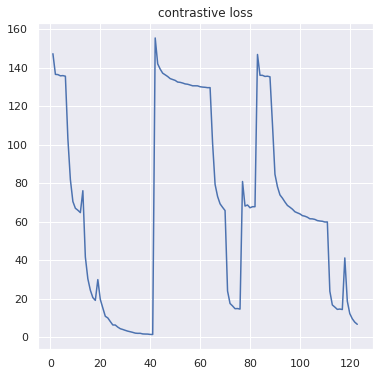

In [8]:
fig = plt.figure(figsize=(6, 6))
contr_ax = plt.subplot()
contr_ax.set_title("contrastive loss")
sns.lineplot(x=range(1, len(cb.train_loss) + 1), y=cb.train_loss, ax=contr_ax)

fig.show()